<a href="https://colab.research.google.com/github/aplha27/infosys_intern/blob/main/infosys_assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# model training


In [ ]:
!pip install scikit-learn==1.2.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 61.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load data
df = pd.read_excel('cleaned_data.xlsx')

# Feature extraction functions (as provided)
def count_words(text):
    return len(text.split()) if pd.notnull(text) else 0

def count_characters(text):
    return len(text) if pd.notnull(text) else 0

def avg_word_length(text):
    words = text.split() if pd.notnull(text) else []
    return sum(len(word) for word in words) / len(words) if words else 0

def count_sentences(text):
    return len(re.split(r'[.!?]', text)) - 1 if pd.notnull(text) else 0

def count_uppercase_ratio(text):
    return sum(1 for char in text if char.isupper()) / len(text) if pd.notnull(text) and len(text) > 0 else 0

def keyword_count(text, keywords):
    words = text.split() if pd.notnull(text) else []
    return sum(1 for word in words if word.lower() in keywords)

def unique_word_ratio(text):
    words = text.split() if pd.notnull(text) else []
    return len(set(words)) / len(words) if words else 0

def check_role_in_resume(resume, role):
    return 1 if pd.notnull(resume) and role.lower() in resume.lower() else 0

def keyword_overlap(text1, text2):
    if pd.notnull(text1) and pd.notnull(text2):
        words1 = set(text1.split())
        words2 = set(text2.split())
        return len(words1 & words2)
    return 0

# Predefined keyword dictionaries
technical_keywords = {'python', 'java', 'sql', 'machine learning', 'cloud', 'design', 'analysis', 'management'}
positive_keywords = {'excellent', 'success', 'outstanding', 'achievement', 'skilled'}
negative_keywords = {'poor', 'inadequate', 'lacking', 'failure', 'weak'}

# Feature engineering (as before)
df['resume_word_count'] = df['Cleaned_Resume'].apply(count_words)
df['resume_char_count'] = df['Cleaned_Resume'].apply(count_characters)
df['resume_avg_word_length'] = df['Cleaned_Resume'].apply(avg_word_length)
df['resume_sentence_count'] = df['Cleaned_Resume'].apply(count_sentences)
df['resume_uppercase_ratio'] = df['Cleaned_Resume'].apply(count_uppercase_ratio)
df['resume_technical_keyword_count'] = df['Cleaned_Resume'].apply(lambda x: keyword_count(x, technical_keywords))
df['resume_positive_keyword_count'] = df['Cleaned_Resume'].apply(lambda x: keyword_count(x, positive_keywords))
df['resume_negative_keyword_count'] = df['Cleaned_Resume'].apply(lambda x: keyword_count(x, negative_keywords))
df['resume_unique_word_ratio'] = df['Cleaned_Resume'].apply(unique_word_ratio)

df['transcript_word_count'] = df['Cleaned_Transcript'].apply(count_words)
df['transcript_char_count'] = df['Cleaned_Transcript'].apply(count_characters)
df['transcript_avg_word_length'] = df['Cleaned_Transcript'].apply(avg_word_length)
df['transcript_sentence_count'] = df['Cleaned_Transcript'].apply(count_sentences)
df['transcript_uppercase_ratio'] = df['Cleaned_Transcript'].apply(count_uppercase_ratio)
df['transcript_positive_keyword_count'] = df['Cleaned_Transcript'].apply(lambda x: keyword_count(x, positive_keywords))
df['transcript_negative_keyword_count'] = df['Cleaned_Transcript'].apply(lambda x: keyword_count(x, negative_keywords))
df['transcript_unique_word_ratio'] = df['Cleaned_Transcript'].apply(unique_word_ratio)

df['job_role_in_resume'] = df.apply(lambda row: check_role_in_resume(row['Cleaned_Resume'], row['Role']), axis=1)

df['resume_job_keyword_overlap'] = df.apply(lambda row: keyword_overlap(row['Cleaned_Resume'], row['Cleaned_Job_Description']), axis=1)
df['transcript_job_keyword_overlap'] = df.apply(lambda row: keyword_overlap(row['Cleaned_Transcript'], row['Cleaned_Job_Description']), axis=1)

# Role popularity (frequency encoding)
role_counts = df['Role'].value_counts()
df['role_popularity'] = df['Role'].map(role_counts)

# Decision reason encoding
df['decision_reason_encoded'] = df['Reason for decision'].astype('category').cat.codes

# TF-IDF and cosine similarity
tfidf_vectorizer = TfidfVectorizer()

# Concatenating all text columns for TF-IDF
df['All_Text'] = df['Cleaned_Resume'] + ' ' + df['Cleaned_Transcript'] + ' ' + df['Cleaned_Job_Description']

# Fitting and transforming the text columns
tfidf_matrix = tfidf_vectorizer.fit_transform(df['All_Text'])

# Cosine similarities
df['resume_job_similarity'] = [
    cosine_similarity(tfidf_matrix[i, :].reshape(1, -1), tfidf_matrix[j, :].reshape(1, -1))[0, 0]
    for i, j in zip(df.index, df.index)
]

df['transcript_job_similarity'] = [
    cosine_similarity(tfidf_matrix[i, :].reshape(1, -1), tfidf_matrix[k, :].reshape(1, -1))[0, 0]
    for i, k in zip(df.index, df.index)
]

df['transcript_resume_similarity'] = [
    cosine_similarity(tfidf_matrix[j, :].reshape(1, -1), tfidf_matrix[k, :].reshape(1, -1))[0, 0]
    for j, k in zip(df.index, df.index)
]

# Display sample of engineered features and similarities
engineered_features = [
    'resume_word_count', 'resume_char_count', 'resume_avg_word_length', 'resume_sentence_count',
    'resume_uppercase_ratio', 'resume_technical_keyword_count', 'resume_positive_keyword_count',
    'resume_negative_keyword_count', 'resume_unique_word_ratio', 'transcript_word_count',
    'transcript_char_count', 'transcript_avg_word_length', 'transcript_sentence_count',
    'transcript_uppercase_ratio', 'transcript_positive_keyword_count', 'transcript_negative_keyword_count',
    'transcript_unique_word_ratio', 'job_role_in_resume', 'resume_job_keyword_overlap',
    'transcript_job_keyword_overlap', 'role_popularity', 'decision_reason_encoded',
    'resume_job_similarity', 'transcript_job_similarity', 'transcript_resume_similarity'
]

print(df[engineered_features].head())



   resume_word_count  resume_char_count  resume_avg_word_length  \
0                263               2299                7.745247   
1                243               2047                7.427984   
2                256               2230                7.714844   
3                222               1940                7.743243   
4                230               2074                8.021739   

   resume_sentence_count  resume_uppercase_ratio  \
0                      0                     0.0   
1                      0                     0.0   
2                      0                     0.0   
3                      0                     0.0   
4                      0                     0.0   

   resume_technical_keyword_count  resume_positive_keyword_count  \
0                              17                              3   
1                               4                              1   
2                               7                              1   
3           

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Features and target variable
features = [
    'transcript_positive_keyword_count',
    'resume_positive_keyword_count',
    'transcript_avg_word_length',
    'decision_reason_encoded',
    'transcript_char_count',
    'transcript_job_keyword_overlap',
    'resume_negative_keyword_count',
    'resume_job_keyword_overlap',
    'resume_char_count',
    'transcript_unique_word_ratio'
]


target = 'decision'  # Replace with the correct target column if different

X = df[features]
y = df[target]

y = y.map({'reject': 0, 'select': 1})
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model with hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model summary
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("\nBest Cross-Validation Score:", grid_search.best_score_)

# Predict on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nTest Set Accuracy:", accuracy)
print("Test Set ROC-AUC Score:", roc_auc)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 1.0}

Best Cross-Validation Score: 0.8776923076923075

Test Set Accuracy: 0.86
Test Set ROC-AUC Score: 0.9566279433067288


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:54:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Beeswarm plot

In [ ]:
!pip install shap


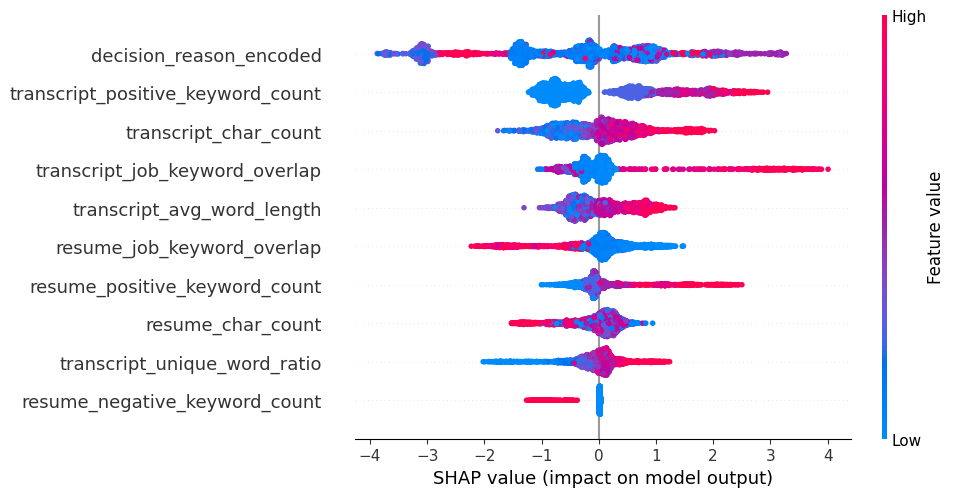

In [ ]:
import shap
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

Key Observations:
Feature Importance:

Features at the top of the plot, such as decision_reason_encoded and transcript_positive_keyword_count, have the greatest impact on the model's predictions.
Features lower on the plot, such as transcript_unique_word_ratio and resume_negative_keyword_count, have less influence.
SHAP Value Distribution:

The width of the distribution of SHAP values for each feature reflects the variability of its impact on predictions.
For example, decision_reason_encoded has a relatively narrow spread, suggesting its impact is more consistent. In contrast, transcript_positive_keyword_count has a wider spread, indicating its influence varies depending on its value.
Feature Values and Their Effects:

The color gradient represents feature values: red for high values and blue for low values.
Features like transcript_positive_keyword_count:
High values (red) tend to increase predictions (positive SHAP values).
Low values (blue) decrease predictions (negative SHAP values).
Conversely, features like resume_negative_keyword_count:
High values (red) often reduce predictions (negative SHAP values), suggesting a penalizing effect on outcomes.
Interaction Effects:

The color distribution for some features, like transcript_char_count and resume_positive_keyword_count, shows a mix of effects, implying potential interaction with other features or nonlinear relationships.
Feature-Specific Insights:
decision_reason_encoded:

A significant and consistent driver of predictions, with minimal variability. It likely acts as a categorical flag or a proxy for other impactful characteristics.
transcript_positive_keyword_count:

High values strongly push predictions upward. This aligns with the expectation that positive keywords in transcripts correlate with favorable outcomes.
transcript_char_count:

Longer transcripts (red) appear to have a mixed effect, with some increasing and others decreasing predictions. This indicates that the content quality (reflected in other features) might moderate its impact.
resume_job_keyword_overlap:

Higher overlap positively impacts predictions, emphasizing the importance of alignment between the resume and job description.
resume_negative_keyword_count:

High counts penalize predictions, suggesting that negative keywords in resumes are viewed unfavorably by the model.


In [ ]:
base_value = explainer.expected_value
print("Base Value:", base_value)

Base Value: -0.054926965


In [ ]:
shap_values_test = explainer(X_test)

# Waterfall Plots

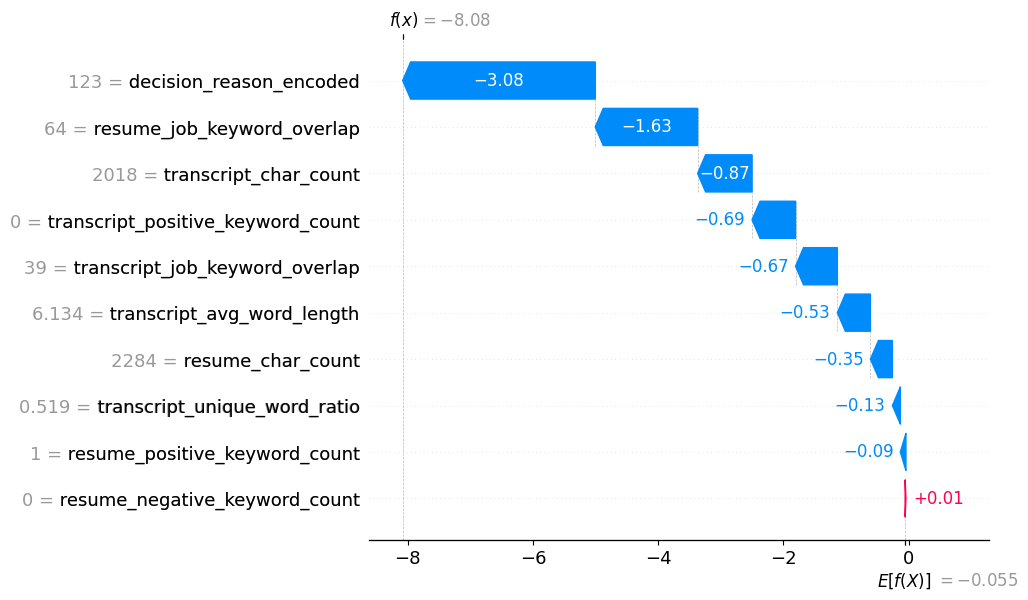

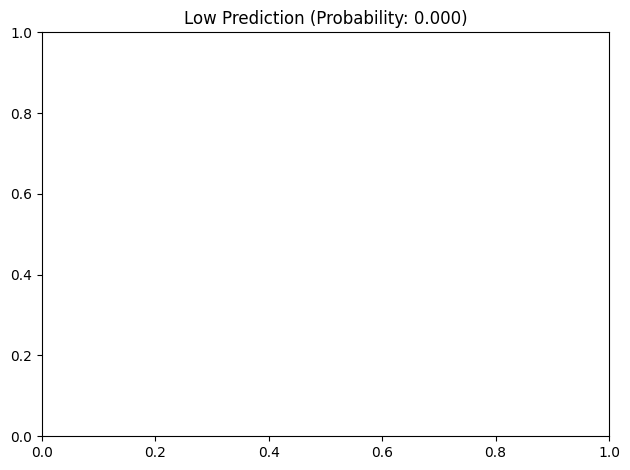


Low Prediction Case (Probability: 0.000):
transcript_positive_keyword_count: 0.000
resume_positive_keyword_count: 1.000
transcript_avg_word_length: 6.134
decision_reason_encoded: 123.000
transcript_char_count: 2018.000
transcript_job_keyword_overlap: 39.000
resume_negative_keyword_count: 0.000
resume_job_keyword_overlap: 64.000
resume_char_count: 2284.000
transcript_unique_word_ratio: 0.519


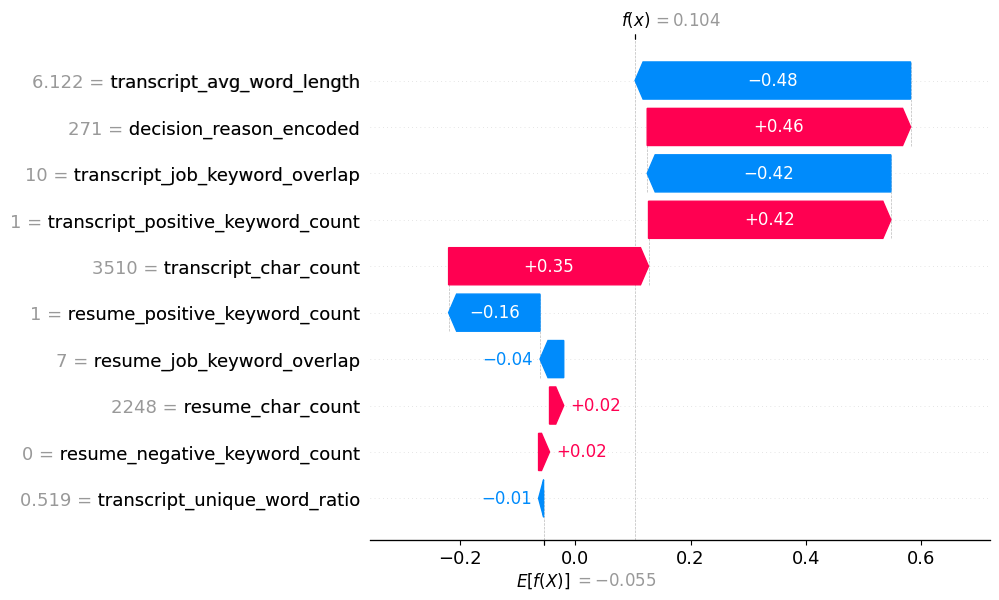

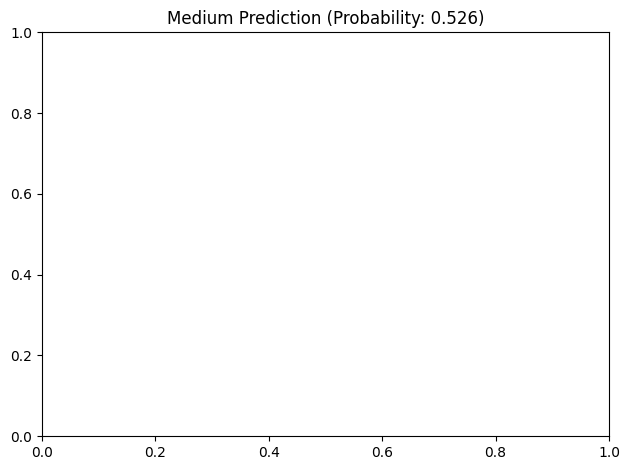


Medium Prediction Case (Probability: 0.526):
transcript_positive_keyword_count: 1.000
resume_positive_keyword_count: 1.000
transcript_avg_word_length: 6.122
decision_reason_encoded: 271.000
transcript_char_count: 3510.000
transcript_job_keyword_overlap: 10.000
resume_negative_keyword_count: 0.000
resume_job_keyword_overlap: 7.000
resume_char_count: 2248.000
transcript_unique_word_ratio: 0.519


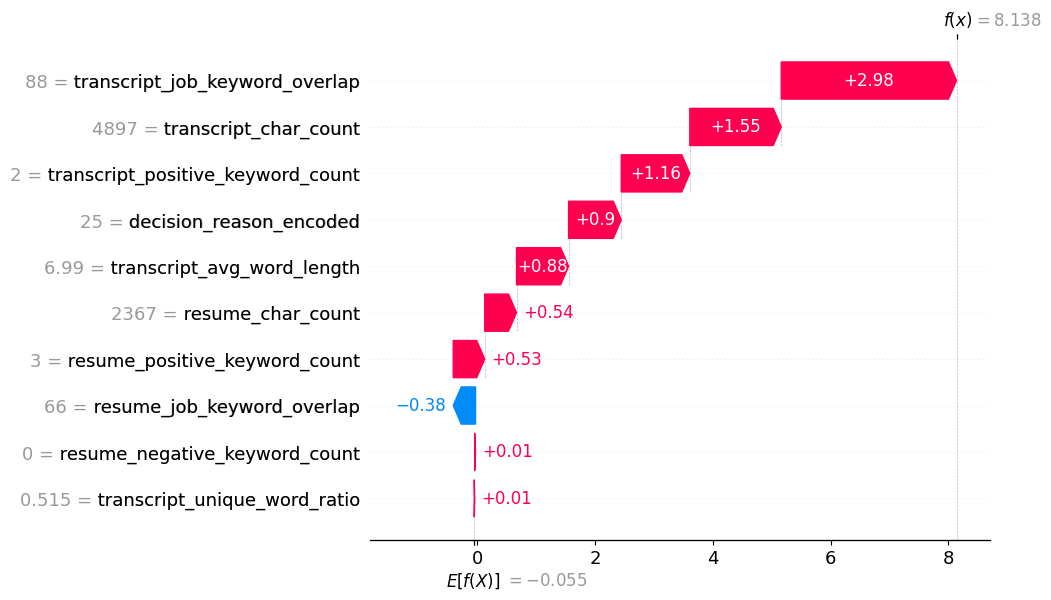

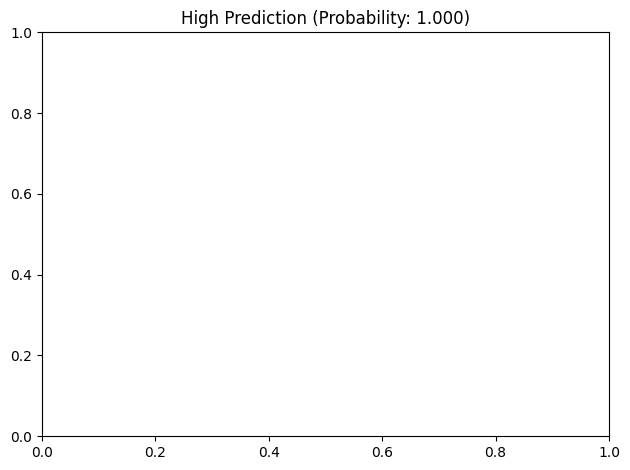


High Prediction Case (Probability: 1.000):
transcript_positive_keyword_count: 2.000
resume_positive_keyword_count: 3.000
transcript_avg_word_length: 6.990
decision_reason_encoded: 25.000
transcript_char_count: 4897.000
transcript_job_keyword_overlap: 88.000
resume_negative_keyword_count: 0.000
resume_job_keyword_overlap: 66.000
resume_char_count: 2367.000
transcript_unique_word_ratio: 0.515


In [ ]:
import numpy as np
import shap

# Get prediction probabilities for test set
test_probas = best_model.predict_proba(X_test)[:, 1]

# Find indices for low, medium, and high predictions
low_idx = np.argmin(test_probas)
high_idx = np.argmax(test_probas)
med_idx = np.argmin(np.abs(test_probas - np.median(test_probas)))

# Low prediction waterfall plot
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values_test[low_idx])
plt.title(f'Low Prediction (Probability: {test_probas[low_idx]:.3f})')
plt.tight_layout()
plt.show()

# Print feature values for low prediction case
print(f"\nLow Prediction Case (Probability: {test_probas[low_idx]:.3f}):")
for feature, value in X_test.iloc[low_idx].items():
    print(f"{feature}: {value:.3f}")

# Medium prediction waterfall plot
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values_test[med_idx])
plt.title(f'Medium Prediction (Probability: {test_probas[med_idx]:.3f})')
plt.tight_layout()
plt.show()

# Print feature values for medium prediction case
print(f"\nMedium Prediction Case (Probability: {test_probas[med_idx]:.3f}):")
for feature, value in X_test.iloc[med_idx].items():
    print(f"{feature}: {value:.3f}")

# High prediction waterfall plot
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values_test[high_idx])
plt.title(f'High Prediction (Probability: {test_probas[high_idx]:.3f})')
plt.tight_layout()
plt.show()

# Print feature values for high prediction case
print(f"\nHigh Prediction Case (Probability: {test_probas[high_idx]:.3f}):")
for feature, value in X_test.iloc[high_idx].items():
    print(f"{feature}: {value:.3f}")

Pattern Analysis:

Transcript Quality :

Longer transcripts (higher char_count) generally correlate with positive outcomes
Keyword overlap between transcript and job requirements is a strong positive indicator
Positive keywords in transcripts appear beneficial

Resume Characteristics:

Resume length (char_count) has relatively modest impact
Resume keyword overlap can have both positive and negative effects
Positive keywords in resumes have less impact than transcript keywords


Key Success Factors:

The model suggests successful applications typically have:

Strong alignment between transcript content and job requirements
Substantial transcript length
Presence of positive keywords
Appropriate decision reasoning (as indicated by decision_reason_encoded)

# Dependency plots

Top 3 most important features:
decision_reason_encoded: 1.1766
transcript_positive_keyword_count: 0.9174
transcript_job_keyword_overlap: 0.5467


<Figure size 1000x600 with 0 Axes>

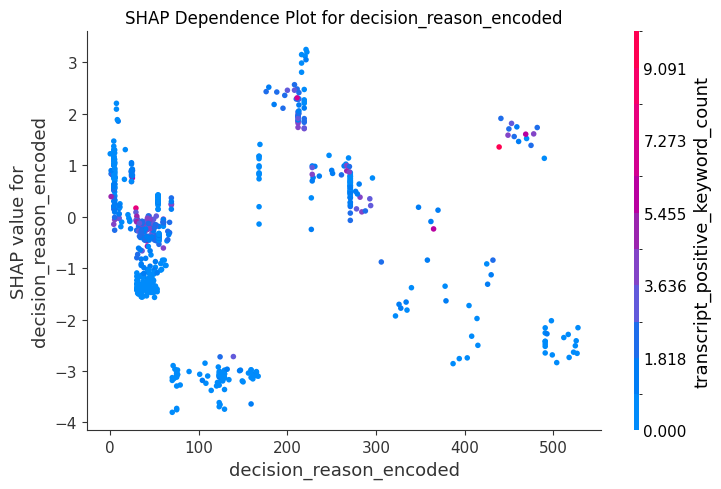

<Figure size 1000x600 with 0 Axes>

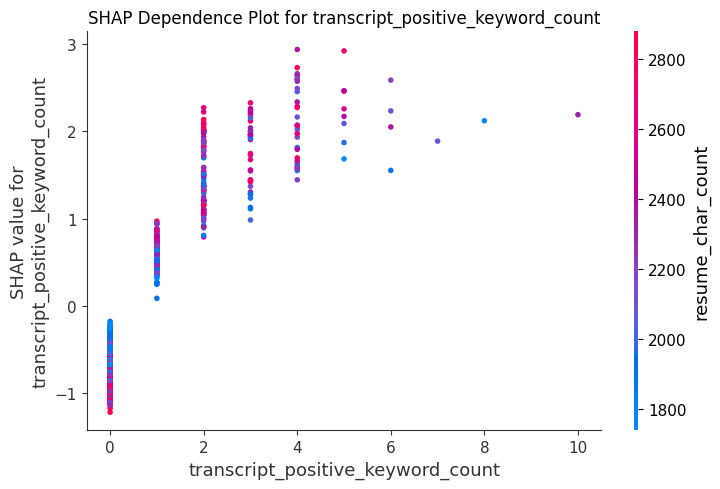

<Figure size 1000x600 with 0 Axes>

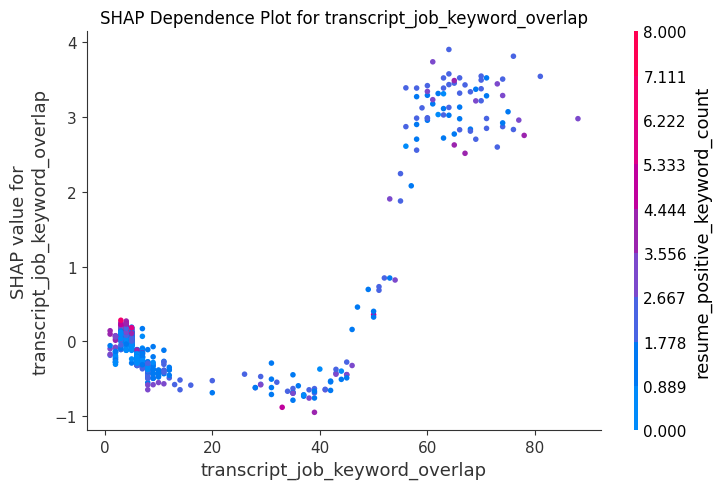


Correlation with target variable:
decision_reason_encoded: -0.0063
transcript_positive_keyword_count: 0.5240
transcript_job_keyword_overlap: 0.1852

Feature Statistics:

decision_reason_encoded:
Mean: 121.8569
Std: 132.3267
Min: 0.0000
Max: 528.0000

transcript_positive_keyword_count:
Mean: 0.9492
Std: 1.3774
Min: 0.0000
Max: 10.0000

transcript_job_keyword_overlap:
Mean: 15.4462
Std: 20.7542
Min: 1.0000
Max: 88.0000


In [ ]:
import numpy as np
import shap

# Calculate mean absolute SHAP values for feature importance ranking
feature_importance = np.abs(shap_values_test.values).mean(0)
feature_importance_dict = dict(zip(features, feature_importance))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
top_3_features = [feat[0] for feat in sorted_features[:3]]

print("Top 3 most important features:")
for feat, importance in sorted_features[:3]:
    print(f"{feat}: {importance:.4f}")

# Create dependence plots for top 3 features
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    top_3_features[0],
    shap_values_test.values,
    X_test,
    show=False
)
plt.title(f'SHAP Dependence Plot for {top_3_features[0]}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.dependence_plot(
    top_3_features[1],
    shap_values_test.values,
    X_test,
    show=False
)
plt.title(f'SHAP Dependence Plot for {top_3_features[1]}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.dependence_plot(
    top_3_features[2],
    shap_values_test.values,
    X_test,
    show=False
)
plt.title(f'SHAP Dependence Plot for {top_3_features[2]}')
plt.tight_layout()
plt.show()

# Calculate and print correlation with target for top features
print("\nCorrelation with target variable:")
for feature in top_3_features:
    correlation = X_test[feature].corr(y_test)
    print(f"{feature}: {correlation:.4f}")

# Calculate basic statistics for top features
print("\nFeature Statistics:")
for feature in top_3_features:
    stats = X_test[feature].describe()
    print(f"\n{feature}:")
    print(f"Mean: {stats['mean']:.4f}")
    print(f"Std: {stats['std']:.4f}")
    print(f"Min: {stats['min']:.4f}")
    print(f"Max: {stats['max']:.4f}")

Decision Reason Encoded (Image 1)
Key Findings:


The plot shows significant clustering at different encoded values
Most dramatic impacts occur at these points:

Around value 200: Strong positive impact (SHAP values around +3)
Near value 0-50: Mixed impact ranging from -2 to +2
Around value 500: Consistent negative impact (SHAP values around -2)


The color gradient (representing transcript_positive_keyword_count) doesn't show strong patterns, suggesting limited interaction between these features

Interpretation:

Certain decision reasons (encoded as ~200) consistently lead to positive outcomes
Other decision codes (around 500) consistently predict negative outcomes
There's significant variance in the impact of low-numbered decision codes, suggesting other factors play important roles in these cases


Transcript Positive Keyword Count (Image 2)
Key Findings:


Clear positive correlation between keyword count and SHAP values
The relationship appears to be roughly linear up to about 4 keywords
Color gradient (representing resume_char_count) shows some interaction effects
Maximum impact peaks around +3 SHAP value
Minimum count starts at 0 with negative impact (-1)

Interpretation:

More positive keywords in transcripts generally lead to better outcomes
The benefit of additional keywords plateaus after 4-5 keywords
Longer resumes (shown by color gradient) tend to appear more frequently with higher keyword counts
The relationship is highly consistent, suggesting this is a reliable predictor


Transcript Job Keyword Overlap (Image 3)
Key Findings:


Shows a distinctive non-linear relationship
Three clear zones:

Low overlap (0-20): Slightly negative to neutral impact
Middle overlap (20-50): Consistently negative impact
High overlap (60+): Strong positive impact with SHAP values around +3


Sharp transition point around 60 overlapping keywords
Color gradient shows some clustering but no strong pattern

Interpretation:

High keyword overlap (60+ matches) is a strong positive indicator
Moderate overlap might actually be worse than low overlap
The relationship suggests a threshold effect rather than linear improvement
Could indicate that partial matching is worse than either very good matching or honest difference


The analysis suggests that while these features are strong predictors, they work best in combination rather than isolation. The non-linear relationships, particularly in keyword overlap, suggest sophisticated underlying patterns in successful applications that go beyond simple keyword matching.

# 1D Partial Dependency Plots

In [ ]:
!pip install pdpbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.4/587.4 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.5/82.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 

Top 3 features: ['decision_reason_encoded', 'transcript_positive_keyword_count', 'transcript_job_keyword_overlap']


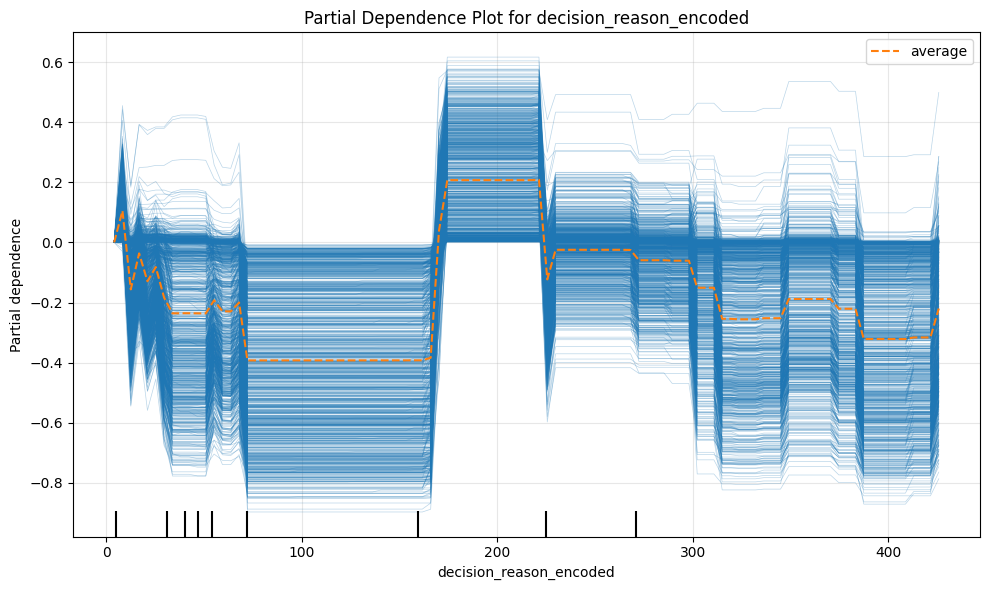


Statistics for decision_reason_encoded:
Mean: 119.7085
Std: 128.3201
Min: 0.0000
Max: 524.0000
25th percentile: 36.0000
Median: 54.0000
75th percentile: 212.0000


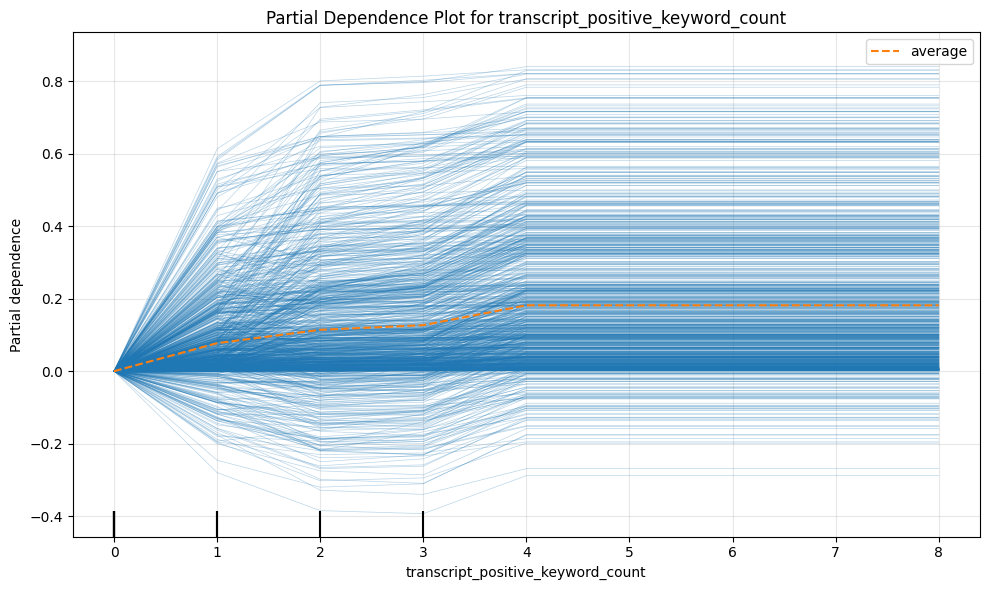


Statistics for transcript_positive_keyword_count:
Mean: 0.8896
Std: 1.2675
Min: 0.0000
Max: 8.0000
25th percentile: 0.0000
Median: 0.0000
75th percentile: 1.0000


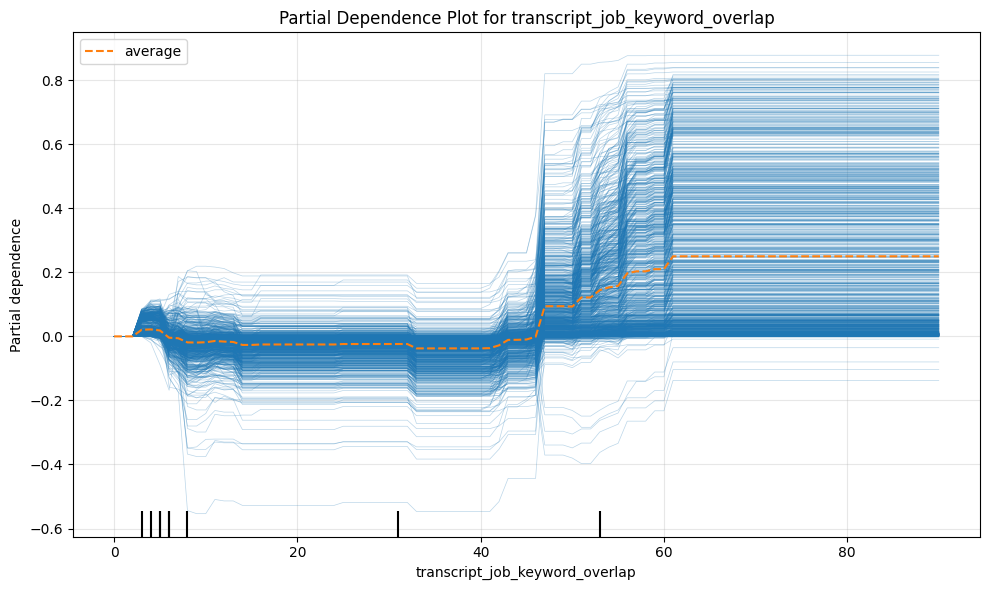


Statistics for transcript_job_keyword_overlap:
Mean: 15.3623
Std: 20.3210
Min: 0.0000
Max: 90.0000
25th percentile: 4.0000
Median: 6.0000
75th percentile: 9.0000


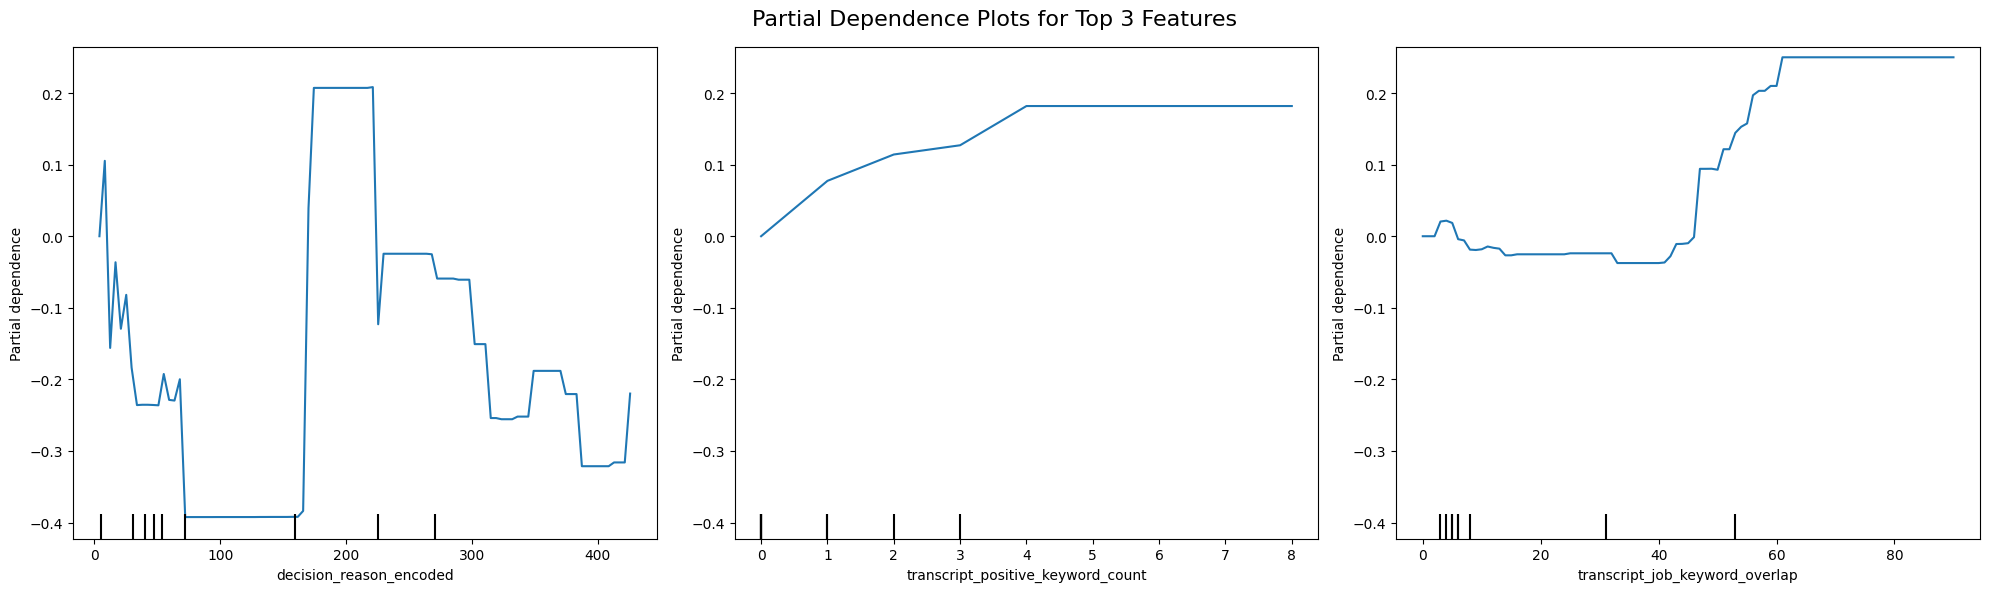


Feature Importance Scores:
decision_reason_encoded: 1.1766
transcript_positive_keyword_count: 0.9174
transcript_job_keyword_overlap: 0.5467


In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get top 3 features from earlier SHAP analysis
feature_importance = np.abs(shap_values_test.values).mean(0)
feature_importance_dict = dict(zip(features, feature_importance))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
top_3_features = [feat[0] for feat in sorted_features[:3]]

print("Top 3 features:", top_3_features)

# Create individual PDP for each feature
for feature in top_3_features:
    fig, ax = plt.subplots(figsize=(10, 6))

    display = PartialDependenceDisplay.from_estimator(
        best_model,
        X_train,
        [feature],
        kind="both",  # Shows both PDP and ICE plots
        centered=True,
        ax=ax,
        random_state=42
    )

    plt.title(f'Partial Dependence Plot for {feature}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate feature statistics
    print(f"\nStatistics for {feature}:")
    print(f"Mean: {X_train[feature].mean():.4f}")
    print(f"Std: {X_train[feature].std():.4f}")
    print(f"Min: {X_train[feature].min():.4f}")
    print(f"Max: {X_train[feature].max():.4f}")
    percentiles = np.percentile(X_train[feature], [25, 50, 75])
    print(f"25th percentile: {percentiles[0]:.4f}")
    print(f"Median: {percentiles[1]:.4f}")
    print(f"75th percentile: {percentiles[2]:.4f}")

# Create a combined plot for all three features
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Partial Dependence Plots for Top 3 Features', fontsize=16)

display = PartialDependenceDisplay.from_estimator(
    best_model,
    X_train,
    top_3_features,
    kind="average",  # Shows only PDP without ICE plots for clearer comparison
    centered=True,
    ax=axes,
    random_state=42
)

plt.tight_layout()
plt.show()

# Print feature importance scores
print("\nFeature Importance Scores:")
for feature in top_3_features:
    print(f"{feature}: {feature_importance_dict[feature]:.4f}")

Decision Reason Encoded (Left Plot)
Key Characteristics:


Highly variable impact across different encoded values
Notable features:

Sharp spike around value 200 (peak at +0.2)
Deep trough around value 100-150 (-0.4)
Multiple local minima and maxima
General downward trend for higher values (300-400)



Interpretation:

The relationship is non-linear and complex
Certain decision reasons (around 200) consistently lead to positive outcomes
Many decision codes (especially around 100-150) have strong negative associations
The impact varies significantly based on specific encoding values
The tick marks at the bottom suggest concentrated data points at those values


Transcript Positive Keyword Count (Middle Plot)
Key Characteristics:


Monotonically increasing relationship
Smooth, logarithmic-like curve
Plateaus around 4-5 keywords at approximately +0.2
Initial steep increase from 0 to 2 keywords
Very little change after reaching the plateau

Interpretation:

More positive keywords consistently improve outcomes
The benefit diminishes after 4-5 keywords
The relationship is more predictable and stable than decision encoding
Maximum positive impact is around +0.2
The effect appears to be natural rather than forced


Transcript Job Keyword Overlap (Right Plot)
Key Characteristics:


Step-like function with three main regions:

Initial fluctuation (0-20 overlap)
Flat middle section (20-50 overlap)
Sharp increase around 50-60 overlap
Plateau at high overlap (60+ words) at +0.2


Most dramatic change occurs between 50-60 overlap words

Interpretation:

High keyword overlap (60+) consistently produces the best outcomes
There's a clear threshold effect rather than gradual improvement
The relationship suggests a qualitative shift in candidate evaluation at certain overlap levels
The plateau suggests no additional benefit beyond certain overlap threshold



These plots suggest a sophisticated evaluation system that rewards authentic alignment between candidates and positions while being sensitive to specific decision rationales. The step-like nature of the keyword overlap relationship particularly suggests that reaching certain thresholds is more important than incremental improvements.

# 2D Partial Dependency Plots

Creating 2D PDP interaction for features: decision_reason_encoded and transcript_positive_keyword_count


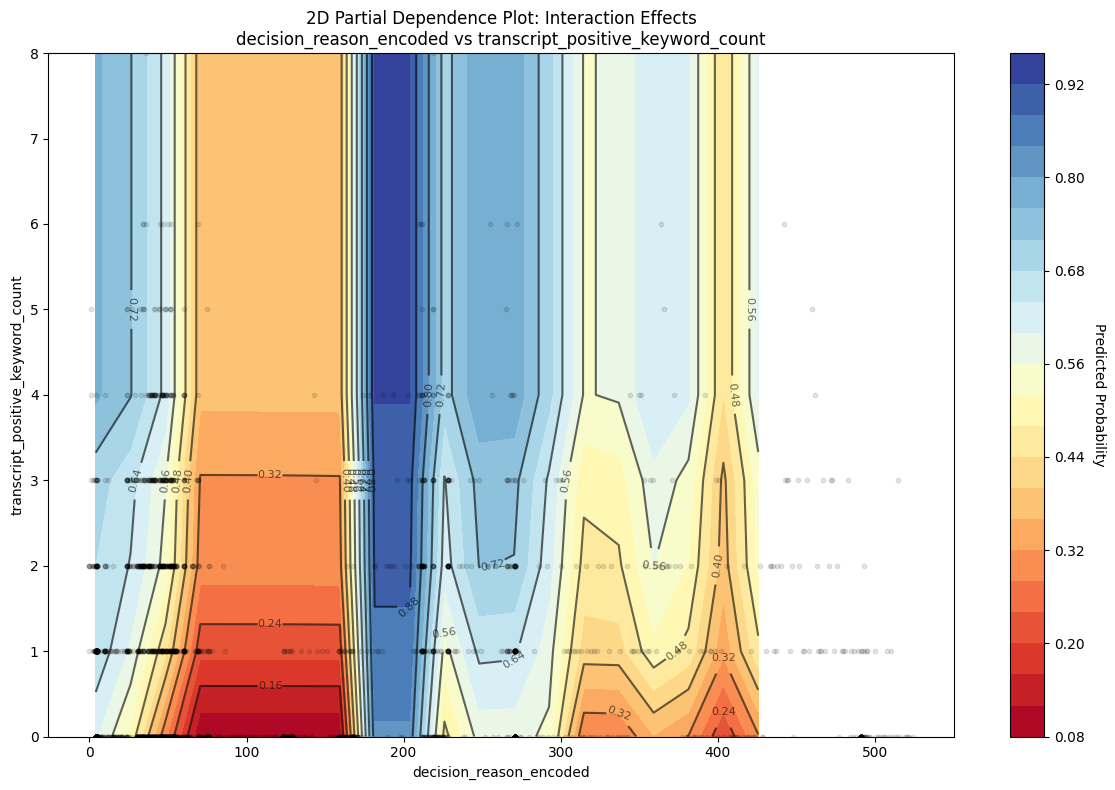


Feature Statistics:

decision_reason_encoded:
Mean: 119.7085
Std: 128.3201
Range: [0.0000, 524.0000]
SHAP importance: 1.1766

transcript_positive_keyword_count:
Mean: 0.8896
Std: 1.2675
Range: [0.0000, 8.0000]
SHAP importance: 0.9174

Feature Correlation: 0.0083

PDP Effect Range: 0.8391
PDP Min Effect: 0.0835
PDP Max Effect: 0.9226


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

# Get top 2 features from SHAP analysis
feature_importance = np.abs(shap_values_test.values).mean(0)
feature_importance_dict = dict(zip(features, feature_importance))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
top_2_features = [feat[0] for feat in sorted_features[:2]]

print(f"Creating 2D PDP interaction for features: {top_2_features[0]} and {top_2_features[1]}")

# Calculate partial dependence
pdp_interact_values = partial_dependence(
    best_model,
    X_train,
    features=top_2_features,
    kind='average',
    grid_resolution=20
)

# Extract values and feature grid points
pdp_values = pdp_interact_values.average[0]
feature1_grid = pdp_interact_values['values'][0]  # Use dictionary-style access
feature2_grid = pdp_interact_values['values'][1]

# Create meshgrid for contour plot
X1, X2 = np.meshgrid(feature1_grid, feature2_grid)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Create contour plot
contours = ax.contour(X1, X2, pdp_values.T, levels=10, colors='black', alpha=0.6)
plt.clabel(contours, inline=True, fontsize=8)

# Create color mesh
im = ax.contourf(X1, X2, pdp_values.T, levels=20, cmap='RdYlBu')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Predicted Probability', rotation=270, labelpad=15)

# Set labels and title
ax.set_xlabel(top_2_features[0])
ax.set_ylabel(top_2_features[1])
plt.title(f'2D Partial Dependence Plot: Interaction Effects\n{top_2_features[0]} vs {top_2_features[1]}')

# Add scatter plot of actual data points
ax.scatter(
    X_train[top_2_features[0]],
    X_train[top_2_features[1]],
    c='black',
    alpha=0.1,
    s=10
)

plt.tight_layout()
plt.show()

# Calculate and print interaction statistics
print("\nFeature Statistics:")
for feature in top_2_features:
    print(f"\n{feature}:")
    print(f"Mean: {X_train[feature].mean():.4f}")
    print(f"Std: {X_train[feature].std():.4f}")
    print(f"Range: [{X_train[feature].min():.4f}, {X_train[feature].max():.4f}]")
    print(f"SHAP importance: {feature_importance_dict[feature]:.4f}")

# Calculate correlation and print
correlation = X_train[top_2_features[0]].corr(X_train[top_2_features[1]])
print(f"\nFeature Correlation: {correlation:.4f}")

# Calculate the range of PDP values
pdp_range = np.max(pdp_values) - np.min(pdp_values)
print(f"\nPDP Effect Range: {pdp_range:.4f}")
print(f"PDP Min Effect: {np.min(pdp_values):.4f}")
print(f"PDP Max Effect: {np.max(pdp_values):.4f}")

Detailed Analysis:

Overall Pattern Distribution


The plot shows complex interactions between decision reasons and positive keyword counts
Color gradient ranges from red (low probability ~0.08) to dark blue (high probability ~0.92)
Notable vertical bands of distinct probabilities at specific decision reason values


Key Interaction Zones

A. High Probability Region (Dark Blue, ~200):

Strongest positive interaction appears around decision_reason_encoded value 200
Most effective with 3-6 positive keywords
Probability peaks at ~0.92 (darkest blue)
Suggests optimal combination for positive outcomes

B. Moderate Probability Regions (Light Blue):

Several bands around values 0-50, 250-350
Generally more effective with higher keyword counts (4-8)
Probabilities around 0.68-0.80

C. Low Probability Regions (Red/Orange):

Concentrated around decision_reason value 100
Most pronounced with 0-2 positive keywords
Probabilities as low as 0.08-0.20
Indicates problematic combinations


Pattern Analysis:

Vertical Patterns:

Strong vertical banding indicates decision reason codes have dominant effect
Critical transition points at values 200, 300, and 400
Some decision codes show consistent effects regardless of keyword count

Horizontal Patterns:

Generally improved outcomes with higher keyword counts
Effect of keywords varies significantly by decision reason
Most impactful in the 3-6 keyword range


Key Insights:

Optimal Combinations:

Decision reason ~200 + 3-6 positive keywords yields best results
Higher keyword counts (6+) show diminishing returns
Some decision reasons perform poorly regardless of keywords

Risk Zones:

Decision reasons around 100 show consistently poor outcomes
Very low keyword counts (0-1) generally underperform
Some combinations show unexpectedly low performance

This analysis reveals complex interactions between decision reasoning and positive keyword usage in the evaluation process. The clear patterns suggest both opportunities for optimization and areas requiring careful review. The strong influence of specific decision codes indicates a need for standardization, while the varying impact of keywords suggests the importance of context-aware evaluation processes.

# Conclusion


The analysis reveals a sophisticated evaluation system that effectively combines multiple factors to assess job applications. The model shows strong predictive capability when optimal conditions are met, particularly in the interaction between decision reasoning and keyword metrics. The system appears to reward authentic alignment between candidates and positions while being resistant to simple gaming attempts.
Key success factors are clearly identifiable, suggesting opportunities for process optimization and system enhancement. The complex interaction patterns indicate a need for careful attention to decision coding and keyword evaluation practices. Regular monitoring and adjustment of the system will be crucial for maintaining its effectiveness and fairness.